### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import nltk
import textwrap   # Wraps the single paragraph in text, and returns a single string containing the wrapped paragraph

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Read the dataset

In [4]:
df = pd.read_csv("npr.csv")

In [5]:
df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


In [80]:
df.shape

(11992, 2)

### Extract the features

In [59]:
# Extract features
features = df['Article']

### Using count vectorizer

In [100]:
vectorizer = CountVectorizer(stop_words = 'english') # since model itself based on wordcount, therefore we are not using TFIDF

In [101]:
X = vectorizer.fit_transform(features)

### Instantiate the LDA

In [105]:
# Instantiate LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(X)

LatentDirichletAllocation(random_state=42)

In [106]:
lda_Z = lda_model.transform(X)

In [107]:
lda_Z.shape

(11992, 10)

### Apply the function

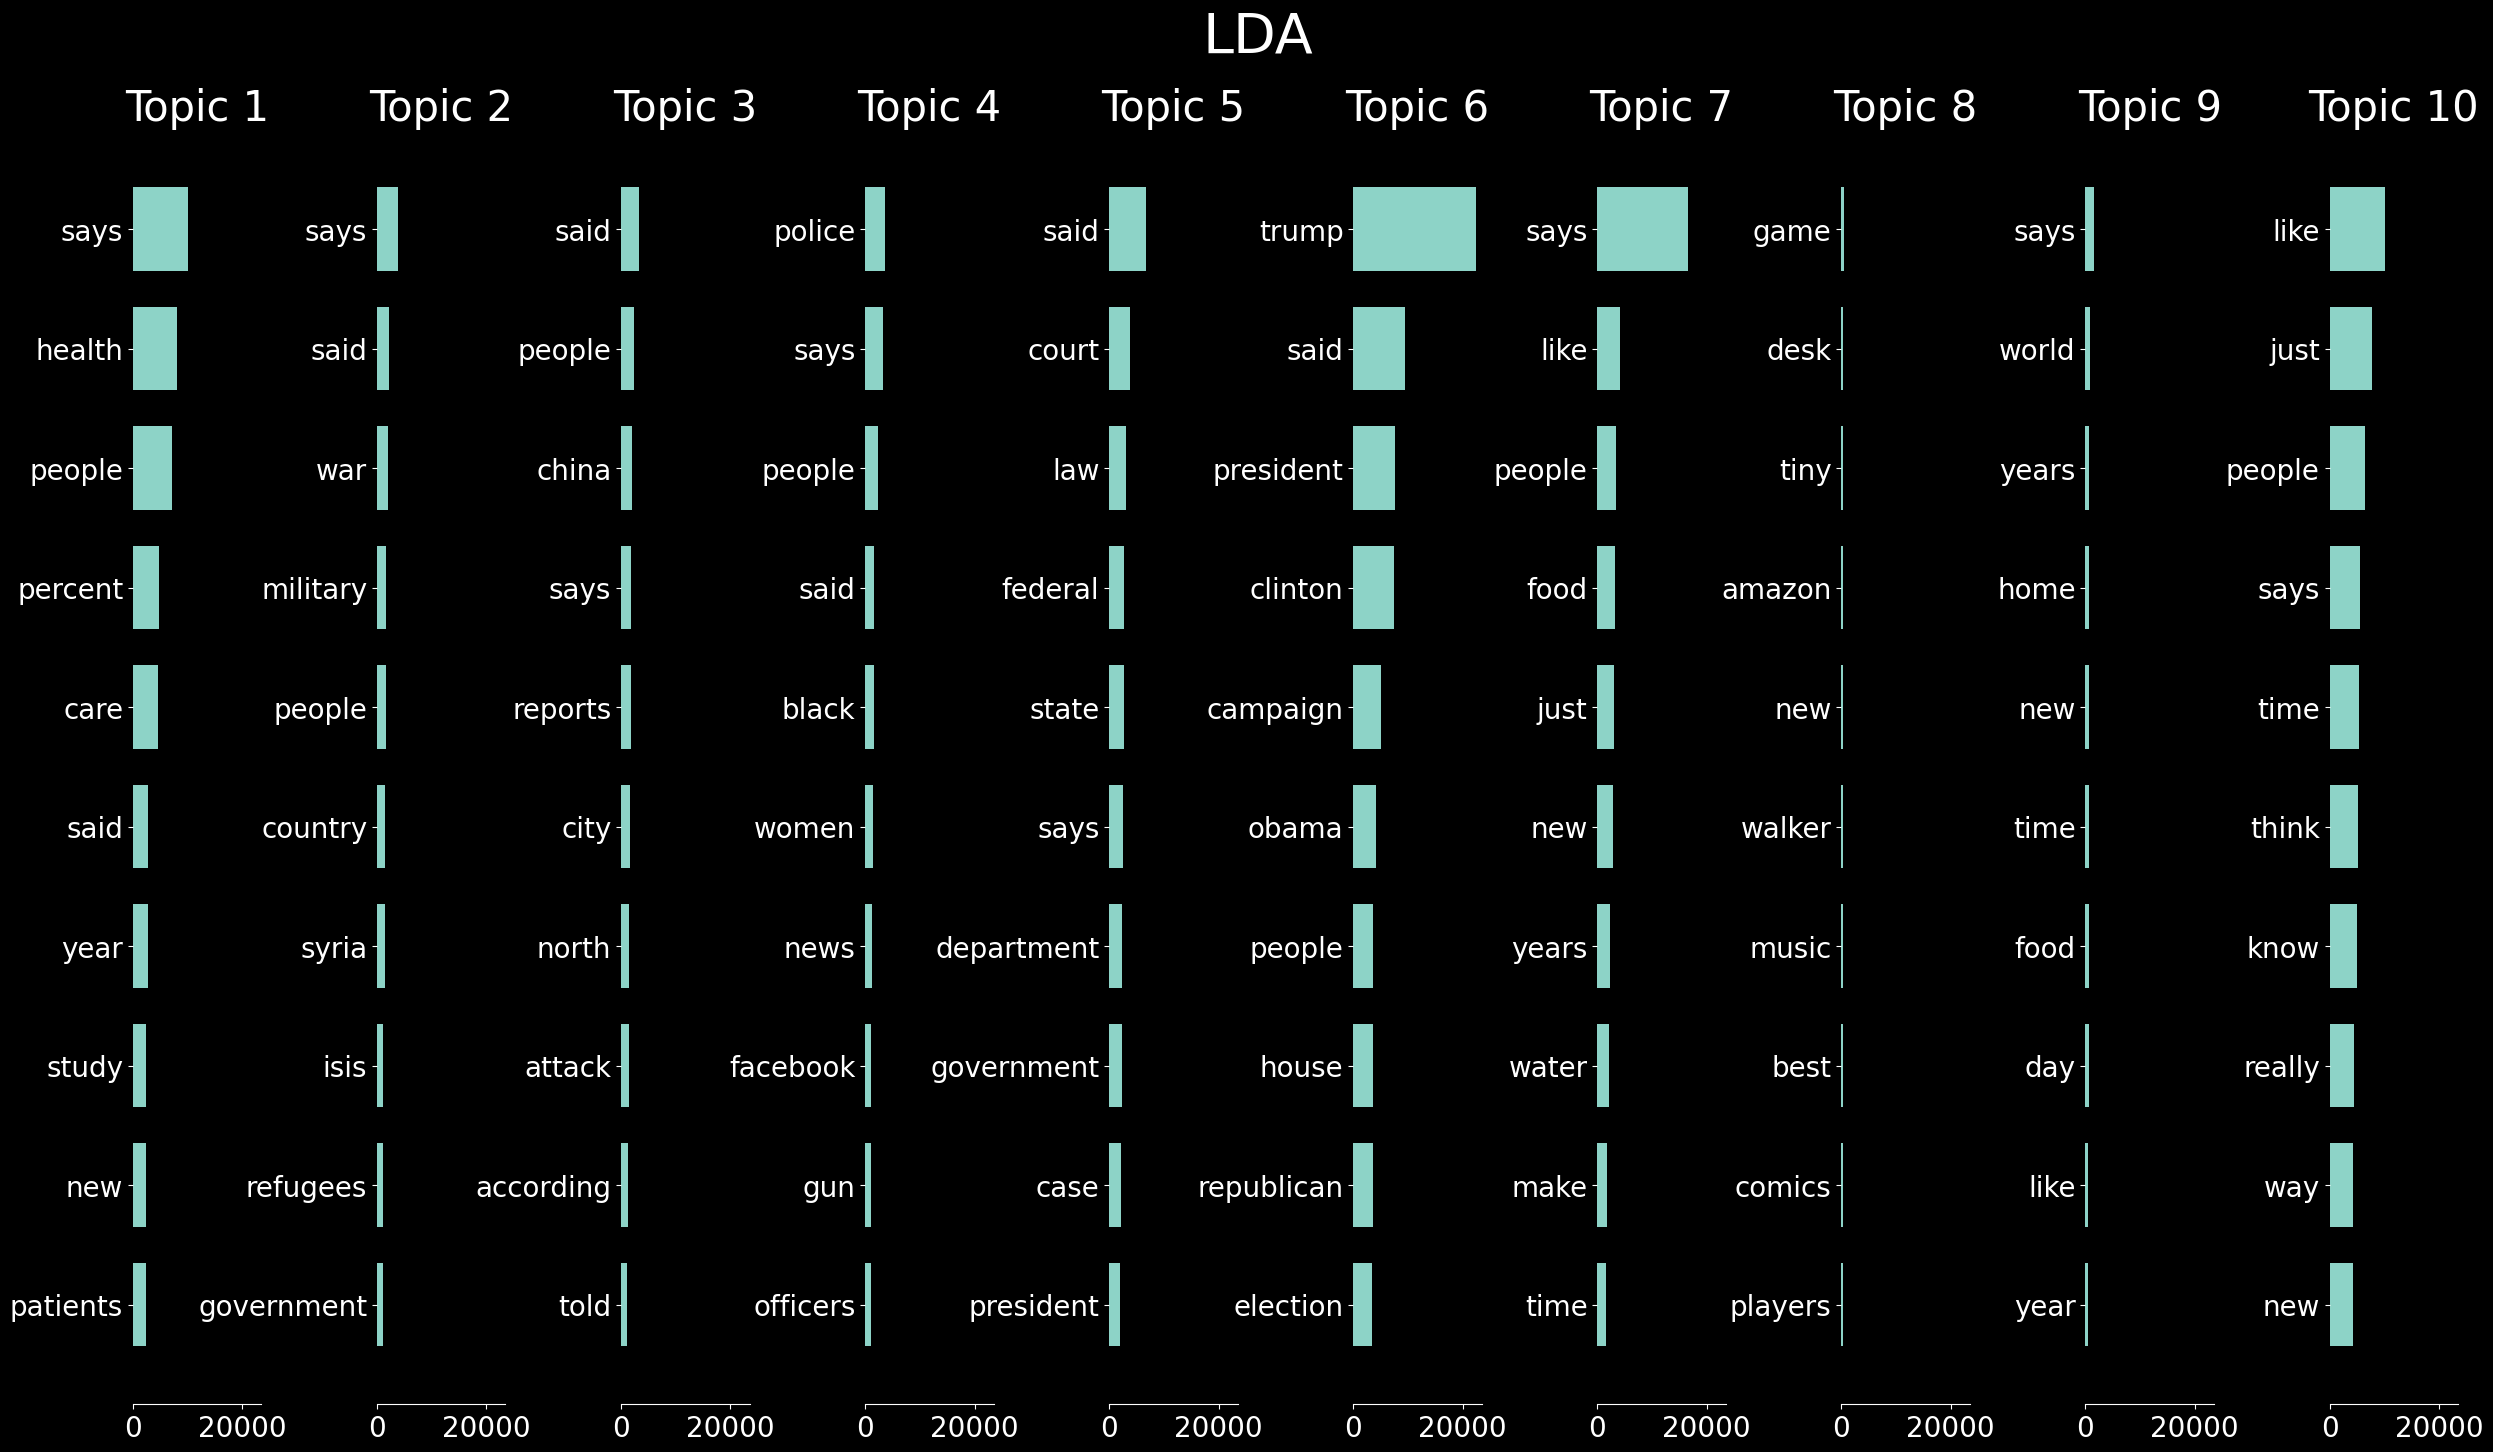

In [108]:
def plot_top_words(model, feature_names, n_top_words=10):
    n_topics = len(model.components_)
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    fig.suptitle('LDA', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Apply the function
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, feature_names)


### Instantiate for NMF

### Using tfidf vectorizer

In [109]:
stops = set(stopwords.words('english'))
stops = stops.union({'would', 'could'})
vectorizer = TfidfVectorizer(stop_words=list(stops))

In [110]:
features = df['Article']

In [111]:
R = vectorizer.fit_transform(features)

In [112]:
nmf_model = NMF(
    n_components=10, # default: 10
    beta_loss="kullback-leibler", # using KL Loss based on the paper recommendation
    solver='mu',  # mu is multiplicative update, we need to define it when we use KL Loss
    random_state = 42,
)

### Instantiate the NMF model

In [113]:
# Instantiate NMF
nmf_model.fit(R)


NMF(beta_loss='kullback-leibler', n_components=10, random_state=42, solver='mu')

In [114]:
nmf_Z = nmf_model.transform(R)


In [115]:
nmf_Z.shape

(11992, 10)

### Apply the function

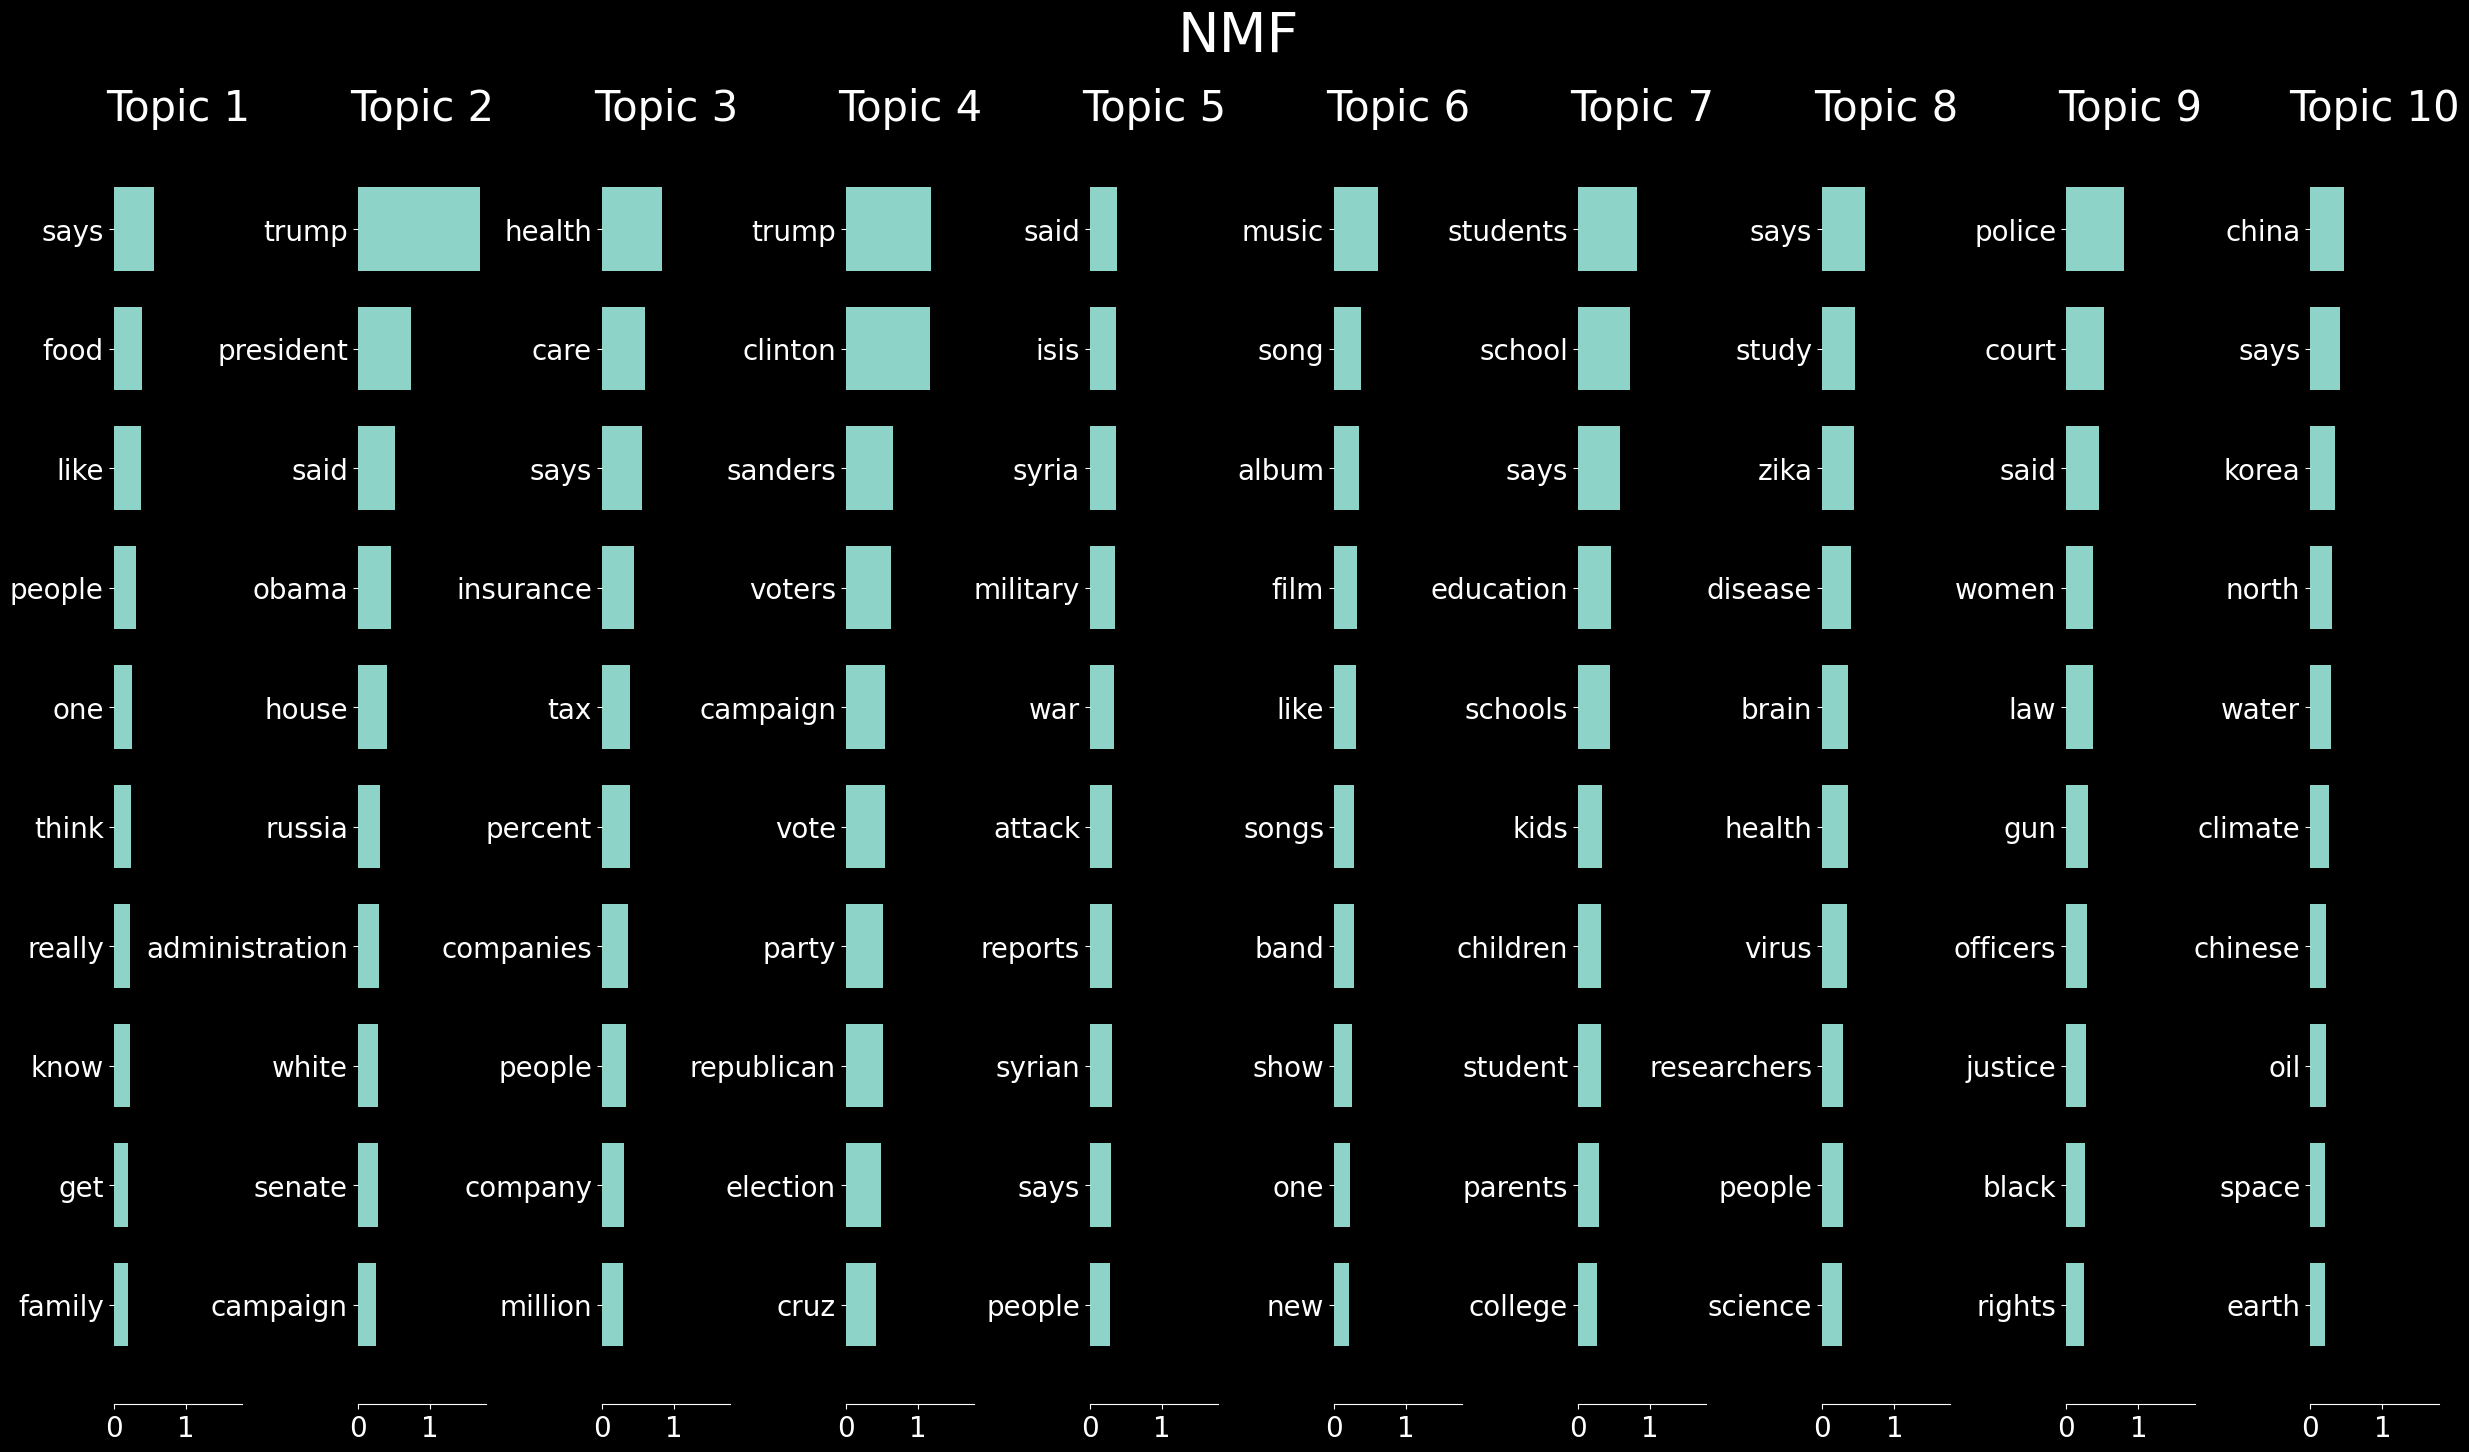

In [116]:
def plot_top_words(model, feature_names, n_top_words=10):
    n_topics = len(model.components_)
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    fig.suptitle('NMF', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Apply the function
feature_names = vectorizer.get_feature_names_out()
plot_top_words(nmf_model, feature_names)


### Group the topics and creating a new column "Topic"

In [117]:
# Combine LDA and NMF topics into a single column
lda_topics = np.argmax(lda_Z, axis=1) + 1  # Adding 1 to match the topic numbering convention
nmf_topics = np.argmax(nmf_Z, axis=1) + 1  # Adding 1 to match the topic numbering convention

In [118]:
# Combine LDA and NMF topics into a single column
topics = [str(lda + nmf) for lda, nmf in zip(lda_topics, nmf_topics)]
df['Topic'] = topics

# Replace underscore with an empty string
df['Topic'] = df['Topic'].str.replace('_', '')

# Group the DataFrame by the combined topics column and count occurrences
grouped_topics = df.groupby('Topic').size().reset_index(name='Count')

# Drop the 'Topics' column
#df.drop('Topics', axis=1, inplace=True)

# Print the DataFrame
print("DataFrame:")
print(df)

DataFrame:
                                                 Article Topic
0      In the Washington of 2016, even when the polic...     8
1        Donald Trump has used Twitter  —   his prefe...     8
2        Donald Trump is unabashedly praising Russian...     8
3      Updated at 2:50 p. m. ET, Russian President Vl...     7
4      From photography, illustration and video, to d...    20
...                                                  ...   ...
11987  The number of law enforcement officers shot an...    13
11988    Trump is busy these days with victory tours,...     8
11989  It’s always interesting for the Goats and Soda...    15
11990  The election of Donald Trump was a surprise to...    10
11991  Voters in the English city of Sunderland did s...    19

[11992 rows x 2 columns]


### checking both the topics of Lda and nmf models

In [120]:
print(lda_topics)

[6 6 6 ... 7 6 9]


In [121]:
nmf_topics

array([ 2,  2,  2, ...,  8,  4, 10])